# Machine Unlearning

### Imports

In [ ]:
# import required libraries
import numpy as np
import tarfile
import os

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.models import resnet18

torch.manual_seed(100)

### Helper Functions

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def training_step(model, batch):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    out = model(images)
    loss = F.cross_entropy(out, labels)
    return loss

def validation_step(model, batch):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    out = model(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'Loss': loss.detach(), 'Acc': acc}

def validation_epoch_end(model, outputs):
    batch_losses = [x['Loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['Acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'Loss': epoch_loss.item(), 'Acc': epoch_acc.item()}

def epoch_end(model, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['Loss'], result['Acc']))

def distance(model,model0):
    distance=0
    normalization=0
    for (k, p), (k0, p0) in zip(model.named_parameters(), model0.named_parameters()):
        space='  ' if 'bias' in k else ''
        current_dist=(p.data0-p0.data0).pow(2).sum().item()
        current_norm=p.data0.pow(2).sum().item()
        distance+=current_dist
        normalization+=current_norm
    print(f'Distance: {np.sqrt(distance)}')
    print(f'Normalized Distance: {1.0*np.sqrt(distance/normalization)}')
    return 1.0*np.sqrt(distance/normalization)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(model, outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))


        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model, epoch, result)
        history.append(result)
        sched.step(result['Loss'])
    return history

## Train/Load the Model

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

100%|██████████| 135107811/135107811 [00:11<00:00, 11836020.38it/s]


['train', 'test']
['deer', 'truck', 'frog', 'airplane', 'ship', 'horse', 'cat', 'dog', 'automobile', 'bird']


### Create a new folder with only some images

In [ ]:
import os
import random
import shutil

def select_percentage_of_images(src_dir, dest_dir, percentage=10):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Iterate through each subdirectory in the source directory
    for subdir in os.listdir(src_dir):
        subdir_path = os.path.join(src_dir, subdir)

        # Check if the item in the source directory is a directory itself
        if os.path.isdir(subdir_path):
            # List all files in the subdirectory
            all_images = os.listdir(subdir_path)

            # Calculate the number of images to select based on the percentage
            num_images_to_select = int(len(all_images) * percentage / 100)

            # Randomly select num_images_to_select from the list of all images
            selected_images = random.sample(all_images, min(num_images_to_select, len(all_images)))

            # Create the destination directory for the subdirectory if it doesn't exist
            dest_subdir_path = os.path.join(dest_dir, subdir)
            if not os.path.exists(dest_subdir_path):
                os.makedirs(dest_subdir_path)

            # Copy the selected images to the destination directory
            for image in selected_images:
                src_image_path = os.path.join(subdir_path, image)
                dest_image_path = os.path.join(dest_subdir_path, image)

                # Copy the selected image to the destination directory
                shutil.copy(src_image_path, dest_image_path)

# Example usage
source_directory = '/content/data/cifar10/train'
destination_directory = '/content/data/cifar10_med/train'
select_percentage_of_images(source_directory, destination_directory, percentage=10)


In [ ]:
# Look into the data directory
data_dir = '/content/data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['deer', 'truck', 'frog', 'airplane', 'ship', 'horse', 'cat', 'dog', 'automobile', 'bird']


In [ ]:
transform_train = tt.Compose([
    tt.ToTensor(),
    tt.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = tt.Compose([
    tt.ToTensor(),
    tt.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
train_ds = ImageFolder(data_dir+'/train', transform_train)
valid_ds = ImageFolder(data_dir+'/test', transform_test)

batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

device = torch.device("cuda")
num_classes = 10
model = resnet18(num_classes = 10).to(device = device)
# model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Model Training

In [ ]:
%%time

epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

torch.save(model.state_dict(), "/content/checkpoints/ResNET18_CIFAR15.pt")

Epoch [0], last_lr: 0.01000, train_loss: 0.5282, val_loss: 0.8242, val_acc: 0.7285
Epoch [1], last_lr: 0.01000, train_loss: 0.4968, val_loss: 0.7866, val_acc: 0.7342
Epoch [2], last_lr: 0.01000, train_loss: 0.4889, val_loss: 0.8469, val_acc: 0.7267
Epoch [3], last_lr: 0.01000, train_loss: 0.4696, val_loss: 0.8101, val_acc: 0.7331
Epoch [4], last_lr: 0.01000, train_loss: 0.4697, val_loss: 0.8560, val_acc: 0.7274
CPU times: user 31 s, sys: 3.04 s, total: 34.1 s
Wall time: 2min 18s


In [ ]:
trained_model_path = "/content/checkpoints/ResNET18_CIFAR15.pt"
model.load_state_dict(torch.load(trained_model_path))
history = [evaluate(model, valid_dl)]
history

[{'Loss': 0.8559949994087219, 'Acc': 0.7274184226989746}]

## Unlearning

In [ ]:
# defining the noise structure
class Noise(nn.Module):
    def __init__(self, *dim):
        super().__init__()
        self.noise = torch.nn.Parameter(torch.randn(*dim), requires_grad = True)

    def forward(self):
        return self.noise

In [ ]:
class_names = train_ds.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# list of all classes
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# classes which are required to un-learn
classes_to_forget = [0,1]

In [ ]:
# classwise list of samples
num_classes = 10
classwise_train = {}
for i in range(num_classes):
    classwise_train[i] = []

for img, label in train_ds:
    classwise_train[label].append((img, label))

classwise_test = {}
for i in range(num_classes):
    classwise_test[i] = []

for img, label in valid_ds:
    classwise_test[label].append((img, label))

KeyboardInterrupt: 

In [ ]:
num_classes = 100
classwise_train = {}
for i in range(num_classes):
    classwise_train[i] = []

for imgs, labels in train_dl:
    imgs, labels = imgs.to(device), labels.to(device)
    for img, label in zip(imgs, labels):
        classwise_train[label.item()].append((img.cpu(), label.cpu()))  # Moving tensors to CPU

classwise_test = {}
for i in range(num_classes):
    classwise_test[i] = []

for imgs, labels in valid_dl:
    imgs, labels = imgs.to(device), labels.to(device)
    for img, label in zip(imgs, labels):
        classwise_test[label.item()].append((img.cpu(), label.cpu()))  # Moving tensors to CPU

In [ ]:
# getting some samples from retain classes
num_samples_per_class = 1000

retain_samples = []
for i in range(len(classes)):
    if classes[i] not in classes_to_forget:
        retain_samples += classwise_train[i][:num_samples_per_class]


In [ ]:
# retain validation set
retain_valid = []
for cls in range(num_classes):
    if cls not in classes_to_forget:
        for img, label in classwise_test[cls]:
            retain_valid.append((img, label))

# forget validation set
forget_valid = []
for cls in range(num_classes):
    if cls in classes_to_forget:
        for img, label in classwise_test[cls]:
            forget_valid.append((img, label))

forget_valid_dl = DataLoader(forget_valid, batch_size, num_workers=3, pin_memory=True)
retain_valid_dl = DataLoader(retain_valid, batch_size*2, num_workers=3, pin_memory=True)

In [ ]:
# loading the model
model_trained = resnet18(num_classes = 10).to(device = device)
model_trained.load_state_dict(torch.load(trained_model_path))

<All keys matched successfully>

In [ ]:
%%time

noises = {}
for cls in classes_to_forget:
    print("Optiming loss for class {}".format(cls))
    noises[cls] = Noise(batch_size, 3, 32, 32).cuda()
    opt = torch.optim.Adam(noises[cls].parameters(), lr = 0.1)

    num_epochs = 5
    num_steps = 8
    class_label = cls
    for epoch in range(num_epochs):
        total_loss = []
        for batch in range(num_steps):
            inputs = noises[cls]()
            labels = torch.zeros(batch_size).cuda()+class_label
            outputs = model(inputs)
            loss = -F.cross_entropy(outputs, labels.long()) + 0.1*torch.mean(torch.sum(torch.square(inputs), [1, 2, 3]))
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss.append(loss.cpu().detach().numpy())
        print("Loss: {}".format(np.mean(total_loss)))

Optiming loss for class 0
Loss: 173.16030883789062
Loss: 29.29629135131836
Loss: -3.028369188308716
Loss: -11.39215087890625
Loss: -15.452569961547852
Optiming loss for class 1
Loss: 173.35226440429688
Loss: 29.959938049316406
Loss: -3.0842535495758057
Loss: -11.97970199584961
Loss: -16.36830711364746
CPU times: user 4.28 s, sys: 45.1 ms, total: 4.33 s
Wall time: 4.43 s


## Impair Step

In [ ]:
%%time

batch_size = 256
noisy_data = []
num_batches = 20
class_num = 0

for cls in classes_to_forget:
    for i in range(num_batches):
        batch = noises[cls]().cpu().detach()
        for i in range(batch[0].size(0)):
            noisy_data.append((batch[i], torch.tensor(class_num)))

other_samples = []
for i in range(len(retain_samples)):
    other_samples.append((retain_samples[i][0].cpu(), torch.tensor(retain_samples[i][1])))
noisy_data += other_samples
noisy_loader = torch.utils.data.DataLoader(noisy_data, batch_size=256, shuffle = True)


optimizer = torch.optim.Adam(model.parameters(), lr = 0.02)


for epoch in range(1):
    model.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(noisy_loader):
        inputs, labels = data
        inputs, labels = inputs.cuda(),torch.tensor(labels).cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(train_ds)},Train Acc:{running_acc*100/len(train_ds)}%")

<timed exec>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
<timed exec>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1: 0.11574149200439453,Train Acc:12.32%
CPU times: user 1.95 s, sys: 92.6 ms, total: 2.04 s
Wall time: 2.05 s


In [ ]:
print("Performance of Standard Forget Model on Forget Class")
history = [evaluate(model, forget_valid_dl)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

print("Performance of Standard Forget Model on Retain Class")
history = [evaluate(model, retain_valid_dl)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

Performance of Standard Forget Model on Forget Class
Accuracy: 0.68359375
Loss: 8.504136085510254
Performance of Standard Forget Model on Retain Class
Accuracy: 70.0244128704071
Loss: 0.8940136432647705


In [ ]:
%%time

heal_loader = torch.utils.data.DataLoader(other_samples, batch_size=256, shuffle = True)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)


for epoch in range(1):
    model.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(heal_loader):
        inputs, labels = data
        inputs, labels = inputs.cuda(),torch.tensor(labels).cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(train_ds)},Train Acc:{running_acc*100/len(train_ds)}%")

<timed exec>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1: 0.060202816467285154,Train Acc:13.922%
CPU times: user 1.83 s, sys: 30.8 ms, total: 1.86 s
Wall time: 1.86 s


In [ ]:
print("Performance of Standard Forget Model on Forget Class")
history = [evaluate(model, forget_valid_dl)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

print("Performance of Standard Forget Model on Retain Class")
history = [evaluate(model, retain_valid_dl)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

Performance of Standard Forget Model on Forget Class
Accuracy: 0.0
Loss: 11.322632789611816
Performance of Standard Forget Model on Retain Class
Accuracy: 72.37304449081421
Loss: 0.9036253690719604


## Grad CAM output for untrained model

In [ ]:
! pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [ ]:
from torchvision import datasets, models, transforms
# initialize a fresh resnet model
model_untrained = models.resnet18(pretrained=True)
num_features = model_untrained.fc.in_features
model_untrained.fc = nn.Linear(num_features, 10) # multi-class classification (num_of_class == 307)
model_untrained = model_untrained.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


In [ ]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
import os
import torchvision
from PIL import Image

def get_first_image_from_subfolders(main_folder):
    image_list = []
    # Iterate through each subfolder in the main folder
    for root, dirs, files in os.walk(main_folder):
        # Check if the folder contains any files
        if files:
            # Filter for image files (you can adjust this condition if needed)
            image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            if image_files:
                # Grab the first image file
                first_image_path = os.path.join(root, image_files[0])
                image_list.append(torchvision.io.read_image(first_image_path))
                # If you just want the path, you can append `first_image_path` instead of `image`
    return image_list

# Example usage:
main_folder = '/content/data/cifar10/test'
test_imgs = get_first_image_from_subfolders(main_folder)


In [ ]:
import torchvision
test_imgs = []

for i in range(num_classes):
  test_img[i] = torchvision.io.read_image(f'/content/data/cifar10_med/test/{class_names[i]}/0085.png')
  test_img[i] = torchvision.transforms.functional.resize(test_img, (224, 224))

RuntimeError: [Errno 2] No such file or directory: '/content/data/cifar10_med/test/bird/0085.png'

In [ ]:

def grad_cam_output(test_img) :
    test_img = torchvision.transforms.functional.resize(test_img, (224, 224))
    target_layers_trained = [model_trained.layer4[-1]]
    target_layers_untrained = [model_untrained.layer4[-1]]
    target_layers_unlearned = [model.layer4[-1]]

    from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from pytorch_grad_cam.utils.image import show_cam_on_image

    cam_trained = GradCAM(model=model_trained, target_layers=target_layers_trained)
    cam_untrained = GradCAM(model=model_untrained, target_layers=target_layers_untrained)
    cam_unlearned = GradCAM(model=model, target_layers=target_layers_unlearned)


    grayscale_cam_trained = cam_trained(input_tensor=test_img.unsqueeze(0).float(), targets=None)
    grayscale_cam_trained = grayscale_cam_trained[0, :]
    rgb_img = test_img.permute(1, 2, 0).numpy()
    rgb_img = rgb_img / 255
    visualization_trained = show_cam_on_image(rgb_img, grayscale_cam_trained, use_rgb=True)

    grayscale_cam_untrained = cam_untrained(input_tensor=test_img.unsqueeze(0).float(), targets=None)
    grayscale_cam_untrained = grayscale_cam_untrained[0, :]
    visualization_untrained = show_cam_on_image(rgb_img, grayscale_cam_untrained, use_rgb=True)

    grayscale_cam_unlearned = cam_unlearned(input_tensor=test_img.unsqueeze(0).float(), targets=None)
    grayscale_cam_unlearned = grayscale_cam_unlearned[0, :]
    visualization_unlearned = show_cam_on_image(rgb_img, grayscale_cam_unlearned, use_rgb=True)

    # Display visualization with matplotlib
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 4, 1)
    plt.title('Original')
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title('Trained Model GradCAM')
    plt.imshow(visualization_trained)
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.title('Untrained Model GradCAM')
    plt.imshow(visualization_untrained)
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title('Unlearned Model GradCAM')
    plt.imshow(visualization_unlearned)
    plt.axis('off')
    plt.show()


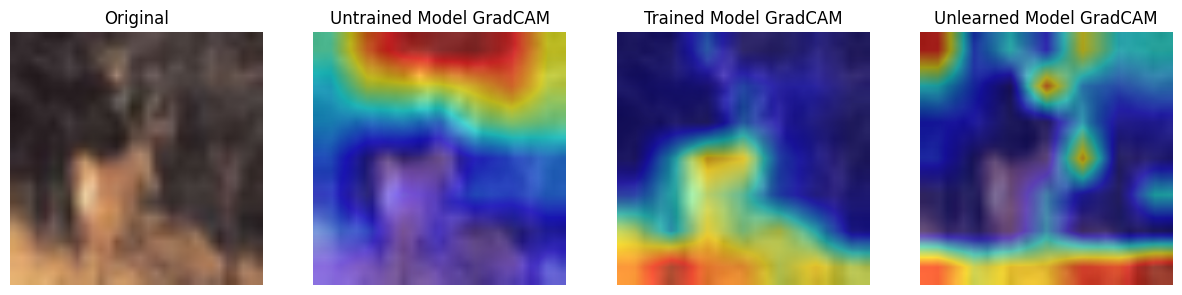

In [ ]:
grad_cam_output(test_imgs[0])

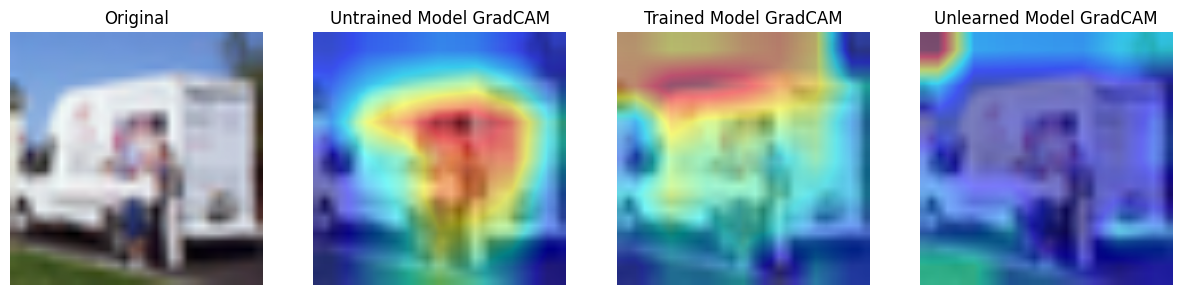

In [ ]:
grad_cam_output(test_imgs[1])

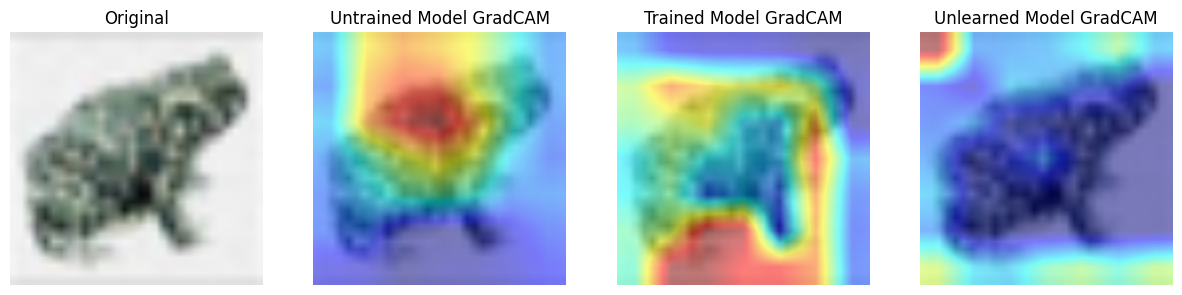

In [ ]:
grad_cam_output(test_imgs[2])

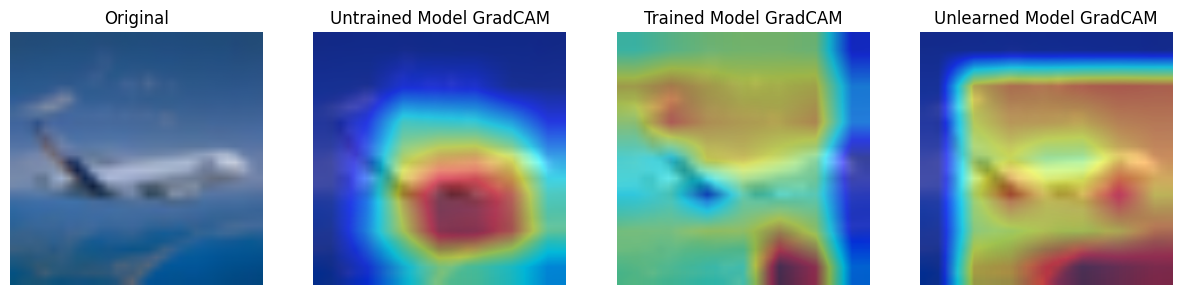

In [ ]:
grad_cam_output(test_imgs[3])

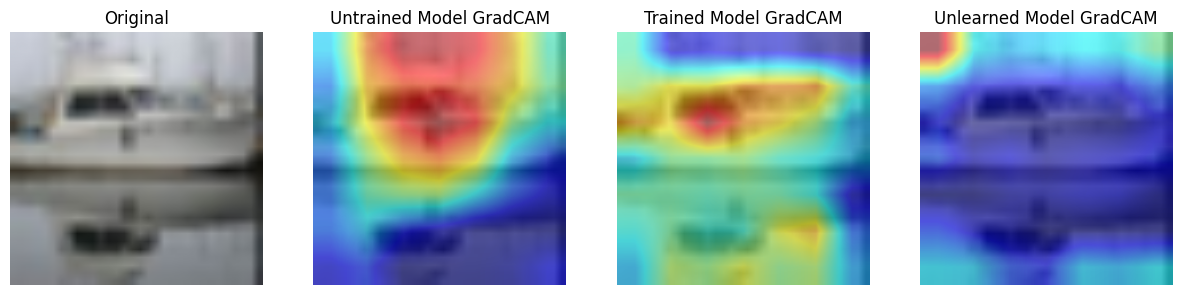

In [ ]:
grad_cam_output(test_imgs[4])

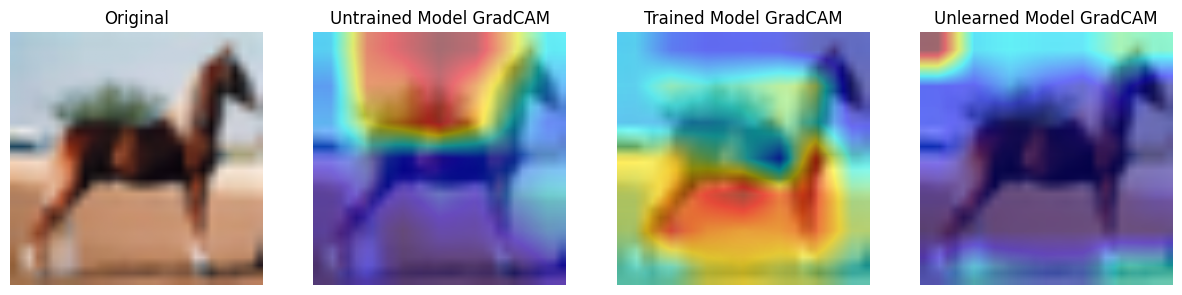

In [ ]:
grad_cam_output(test_imgs[5])

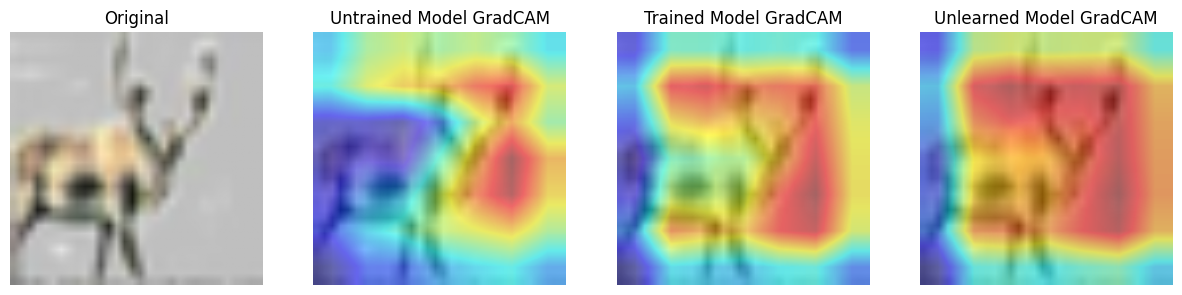

In [ ]:
grad_cam_output(test_imgs[6])

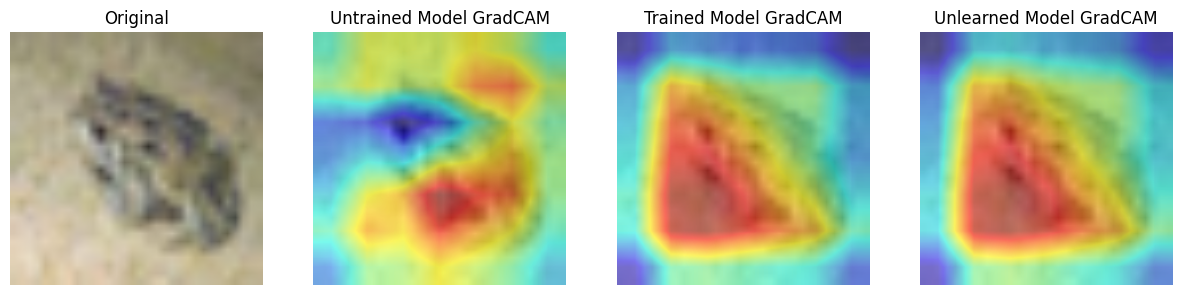

In [ ]:
grad_cam_output(test_imgs[7])

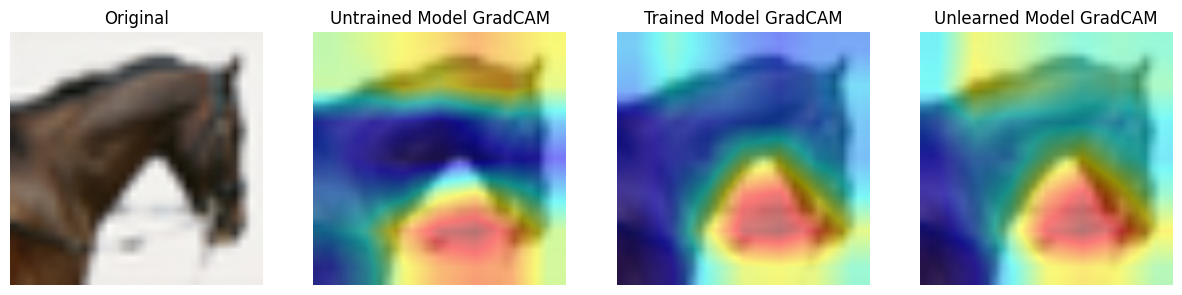

In [ ]:
grad_cam_output(test_imgs[8])

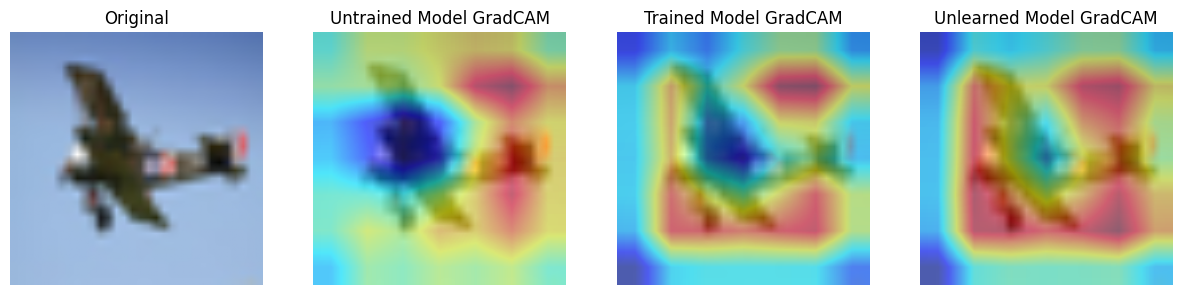

In [ ]:
grad_cam_output(test_imgs[9])

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_random_images(folder_path, num_images=5):
    # Get list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Select num_images random images
    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    # Plot the selected images
    num_rows = (num_images + 4) // 5  # Calculate number of rows for the grid
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

    for i, image_file in enumerate(selected_images):
        img = mpimg.imread(os.path.join(folder_path, image_file))
        if num_rows > 1:
            axes[i//5, i%5].imshow(img)
            axes[i//5, i%5].axis('off')
            axes[i//5, i%5].set_title(image_file)
        else:
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(image_file)

    # Hide empty subplots
    for j in range(num_images, num_rows*5):
        if num_rows > 1:
            axes[j//5, j%5].axis('off')
        else:
            axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:



In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_random_images(folder_path, num_images=5):
    # Get list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Select num_images random images
    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    # Plot the selected images
    num_rows = (num_images + 4) // 5  # Calculate number of rows for the grid
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

    for i, image_file in enumerate(selected_images):
        img = mpimg.imread(os.path.join(folder_path, image_file))
        if num_rows > 1:
            axes[i//5, i%5].imshow(img)
            axes[i//5, i%5].axis('off')
            axes[i//5, i%5].set_title(image_file)
        else:
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(image_file)

    # Hide empty subplots
    for j in range(num_images, num_rows*5):
        if num_rows > 1:
            axes[j//5, j%5].axis('off')
        else:
            axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:



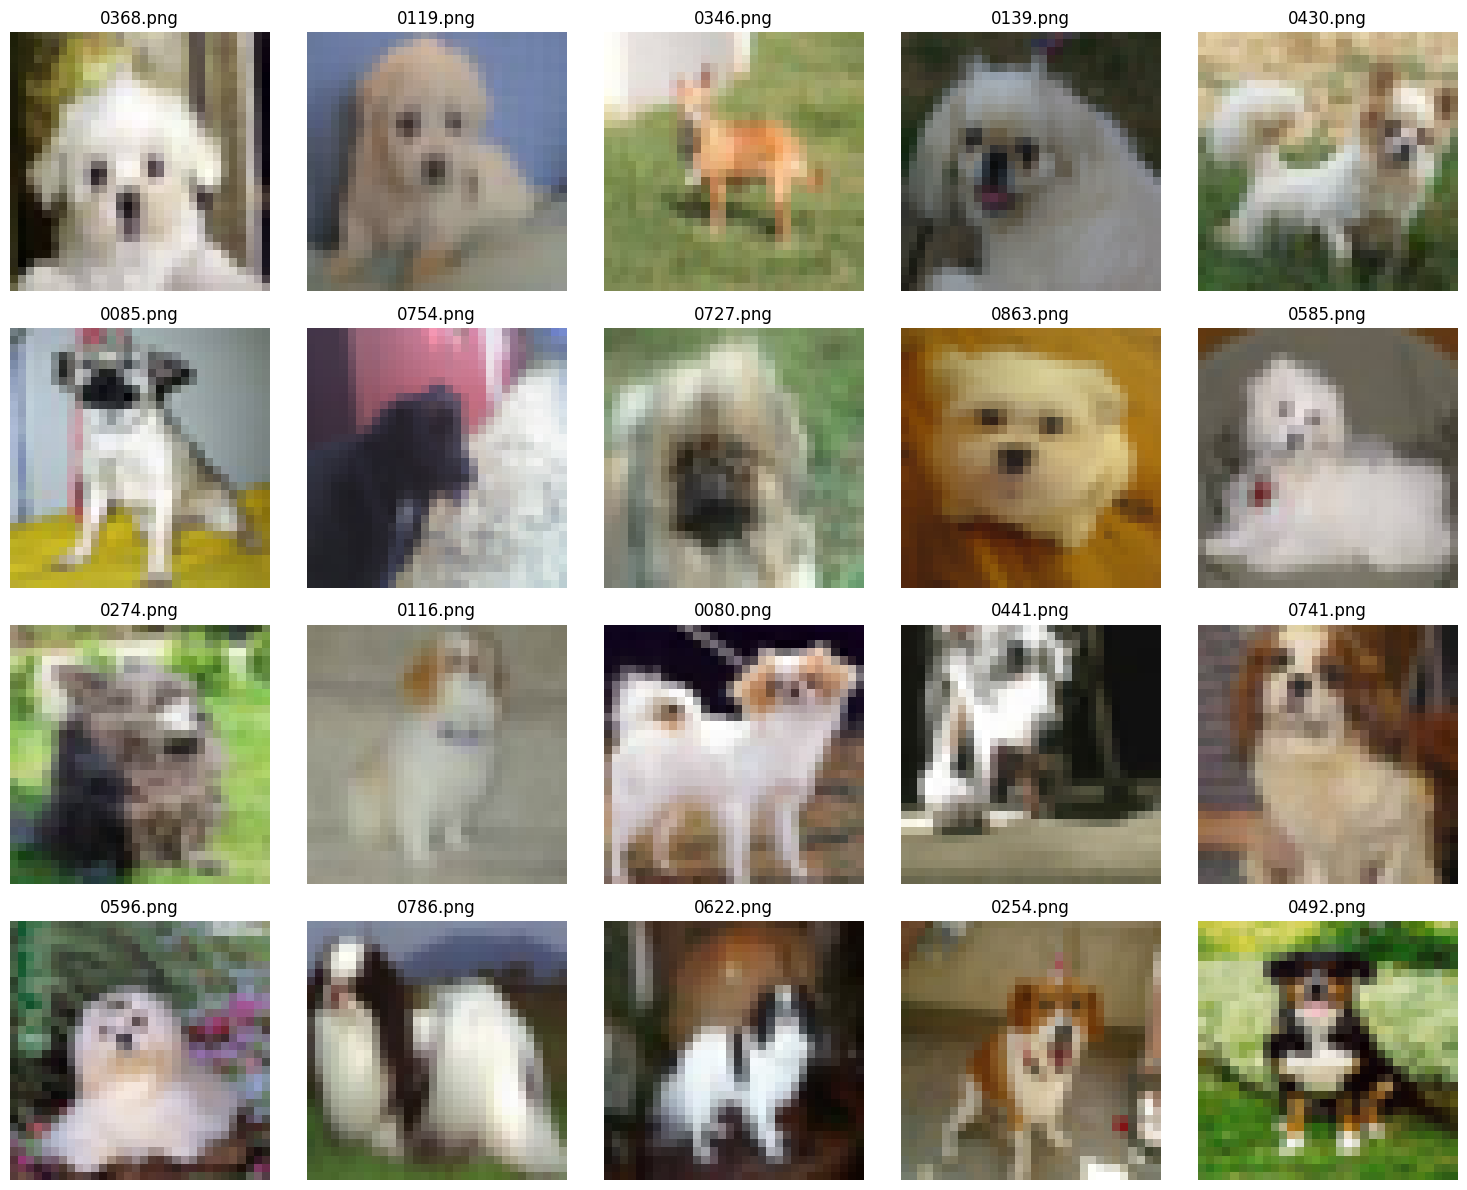

In [ ]:
folder_path = '/content/data/cifar10/test/dog'
plot_random_images(folder_path, 20)

In [ ]:
input_folder = '/content/data/cifar10/test/dog'
image_list = ['0753.png', '0081.png', '0387.png', '0200.png', '0492.png']  # List of image filenames
import torchvision
test_img = []

for i in range(len(image_list)):
  test_img.append(torchvision.io.read_image(f'{input_folder}/{image_list[i]}'))
  test_img[i] = torchvision.transforms.functional.resize(test_img[i], (224, 224))

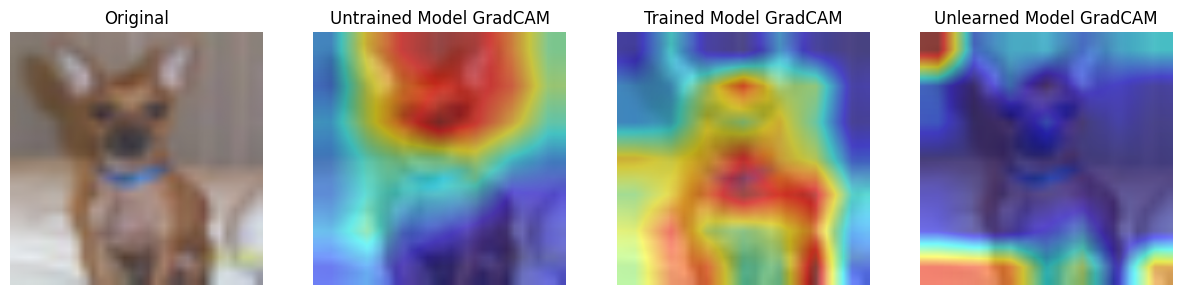

In [ ]:
grad_cam_output(test_img[0])

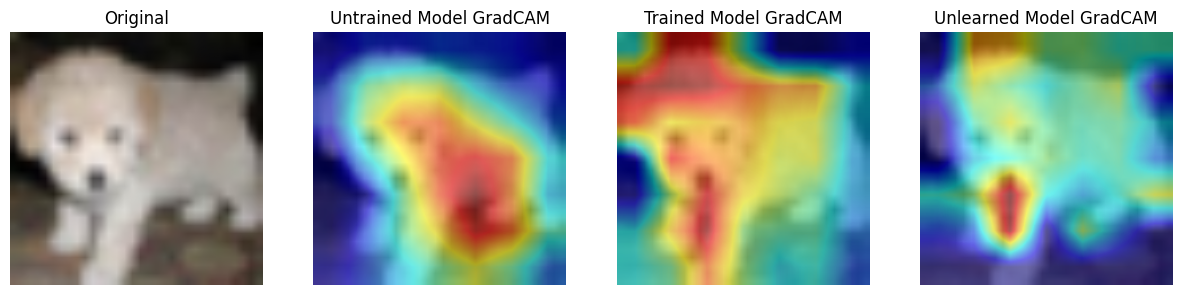

In [ ]:
grad_cam_output(test_img[1])

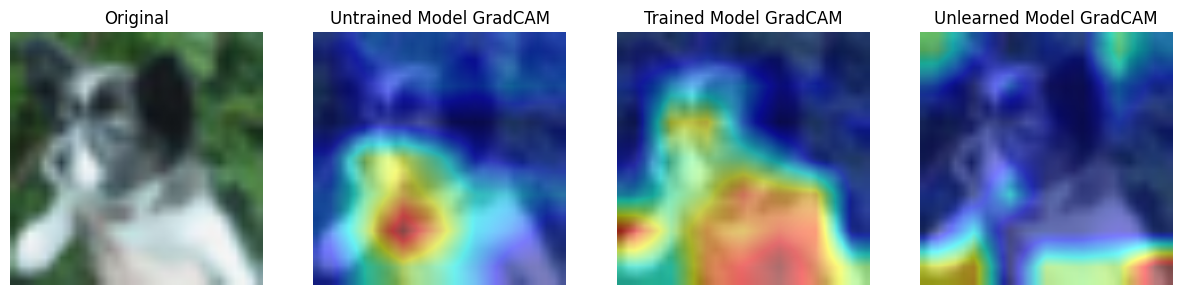

In [ ]:
grad_cam_output(test_img[2])

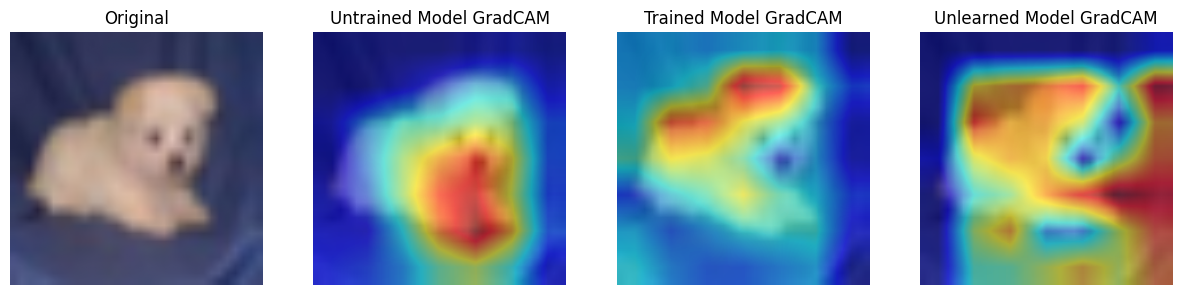

In [ ]:
grad_cam_output(test_img[3])

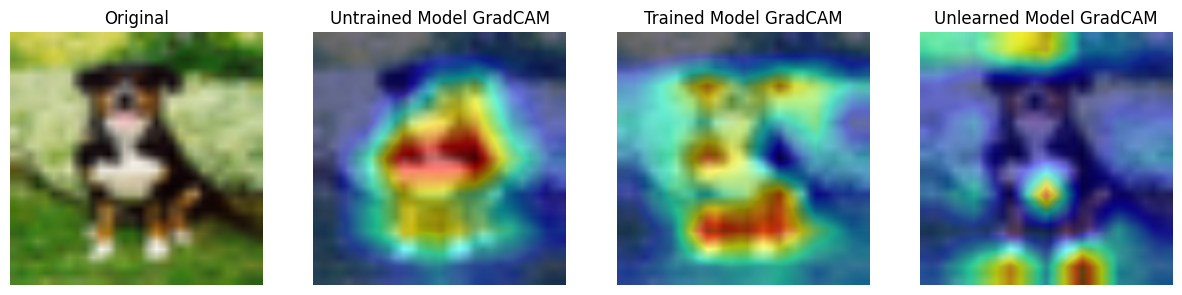

In [ ]:
grad_cam_output(test_img[4])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


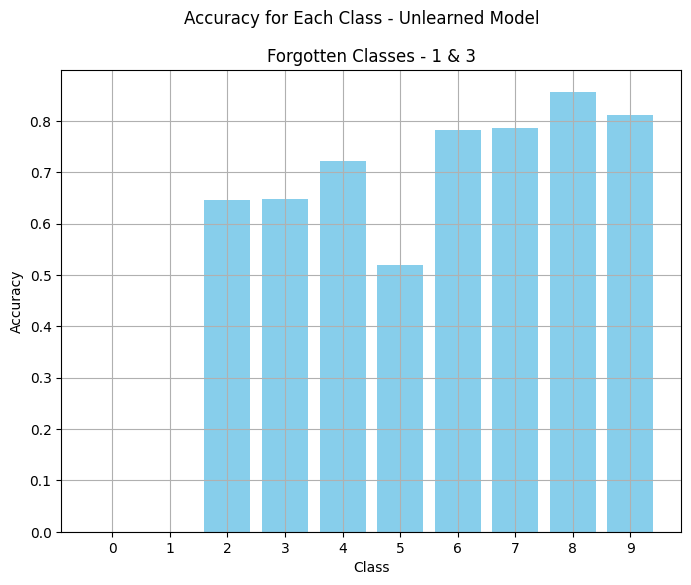

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a test data loader named test_loader
# and a trained model named model with 10 output classes

# Initialize counters for correct predictions for each class
num_classes = 10
correct_predictions = [0] * num_classes
total_predictions = [0] * num_classes

# Iterate through the test dataset
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in valid_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Count correct predictions for each class
        for i in range(num_classes):
            correct_predictions[i] += torch.sum((predicted == labels) & (labels == i)).item()
            total_predictions[i] += torch.sum(labels == i).item()

# Calculate accuracy for each class
accuracies = [correct / total if total != 0 else 0 for correct, total in zip(correct_predictions, total_predictions)]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.bar(range(num_classes), accuracies, color='skyblue')
plt.suptitle('Accuracy for Each Class - Unlearned Model')
plt.title('Forgotten Classes - 1 & 3')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(range(num_classes))
plt.grid(True)
plt.show()


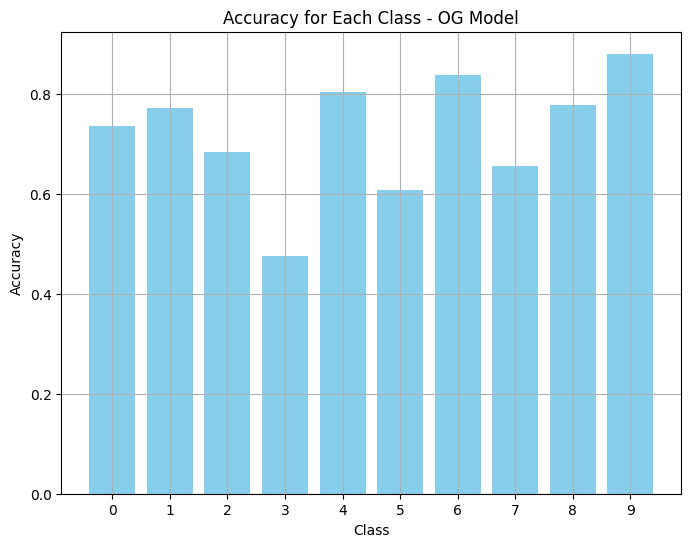

In [ ]:
# loading the og_model
og_model = resnet18(num_classes = 10).to(device = device)
og_model.load_state_dict(torch.load(trained_model_path))

import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a test data loader named test_loader
# and a trained model named model with 10 output classes

# Initialize counters for correct predictions for each class
num_classes = 10
correct_predictions = [0] * num_classes
total_predictions = [0] * num_classes

# Iterate through the test dataset
og_model.eval()  # Set the og_model to evaluation mode
with torch.no_grad():
    for inputs, labels in valid_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = og_model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Count correct predictions for each class
        for i in range(num_classes):
            correct_predictions[i] += torch.sum((predicted == labels) & (labels == i)).item()
            total_predictions[i] += torch.sum(labels == i).item()

# Calculate accuracy for each class
accuracies = [correct / total if total != 0 else 0 for correct, total in zip(correct_predictions, total_predictions)]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.bar(range(num_classes), accuracies, color='skyblue')
plt.title('Accuracy for Each Class - OG Model')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(range(num_classes))
plt.grid(True)
plt.show()
